# Part 2

This section focuses on Use case 1 described in the paper on investigating TR heterozygosity and allele distribution.

Code used in this notebook is adapted from the codebase that is available here https://github.com/gymreklab/1000Genomes-TR-Analysis

In [1]:
# required software
!bash check_software.sh bcftools statSTR | grep "NOT installed"

In [2]:
# get chrom,pos,period and repeat unit
!bcftools query -f"%CHROM\t%POS\t%INFO/PERIOD\t%INFO/RU\n" output/ensembletr_output/ensembletr.vcf.gz > downstream/motif_info.tab
!cat motif_info.tab

chr1	77887913	3	AAG
chr4	3074877	3	AGC
chr4	3074940	3	CCG
chr11	57528484	2	AT
chr14	64253561	2	AC
chr17	51831668	3	AGC
chr21	43776443	12	CCCCGCCCCGCG


In [5]:
# import libraries
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn as sns

### Distribution of the fraction of non-reference alleles in individuals by super population

In the cell below variants from each population to a Python script that counts the number of reference  and non-reference alleles for each sample. It returns a file with three columns sample, reference allele count and non-reference count

In [1]:
%%bash 

populations=("africa" "europe" "east_asia" "south_asia" "america")

for population in "${populations[@]}"; do

    bcftools view -S str_resources/"${population}"_sample_ids.txt output/ensembletr_output/ensembletr.vcf.gz \
        | python3 qc.py "${population}"

done

defaultdict(<class 'int'>, {'HG03054': 3, 'NA19023': 2, 'NA19152': 2, 'NA19700': 4, 'HG02646': 1, 'HG03060': 3, 'HG03385': 2, 'HG03472': 1, 'NA20278': 1, 'HG03458': 1, 'HG02465': 1, 'NA18510': 1})
defaultdict(<class 'int'>, {'HG00120': 3, 'HG00185': 1, 'HG00188': 1, 'HG00231': 1, 'HG00242': 2, 'HG00342': 1, 'HG00343': 2, 'HG00358': 2, 'HG01673': 1, 'HG01679': 3, 'HG01685': 2, 'NA10847': 1, 'NA12046': 2, 'NA20518': 2, 'NA20542': 1, 'NA20802': 3, 'HG00313': 1, 'NA11830': 1})


defaultdict(<class 'int'>, {'HG00613': 3, 'HG00437': 2, 'HG00457': 1, 'HG00671': 1, 'HG01807': 1, 'HG01863': 2, 'HG02061': 1, 'HG02139': 2, 'HG02181': 2, 'HG02379': 1, 'NA18559': 2, 'NA18639': 1, 'NA18954': 1, 'NA18974': 2, 'NA19064': 1, 'NA19066': 2, 'NA19079': 1})
defaultdict(<class 'int'>, {'HG03848': 3, 'HG02649': 3, 'HG03491': 3, 'HG03595': 1, 'HG03684': 1, 'HG03733': 2, 'HG03780': 2, 'HG03787': 1, 'HG03792': 2, 'HG03830': 2, 'HG03868': 1, 'HG03885': 2, 'HG03953': 3, 'HG03965': 1, 'HG04003': 2, 'HG04093': 2, 'HG04238': 2, 'NA21093': 2, 'NA21101': 2, 'HG03652': 1})
defaultdict(<class 'int'>, {'HG01365': 2, 'HG00742': 2, 'HG01054': 2, 'HG01063': 1, 'HG01097': 3, 'HG01205': 2, 'HG01250': 3, 'HG01272': 1, 'HG01369': 2, 'HG01383': 3, 'HG01468': 3, 'HG01976': 1, 'HG02006': 3, 'HG02105': 3, 'HG02286': 2, 'NA19670': 3, 'NA19734': 2, 'NA19752': 2})


The code below calculates the proportion of non-reference alleles for each super population. 

Boxplots summarize the distribution of the fraction of variant alleles. Horizontal lines show median values, boxes span from the 25th percentile (Q1) to the 75th percentile (Q3). Whiskers extend to Q1–1.5IQR (bottom) and Q3 + 1.5IQR (top), where IQR gives the interquartile range (Q3-Q1).

In [19]:
super_populations = ["africa", "europe", "east_asia", "south_asia", "america"]

df = pd.DataFrame(columns = super_populations)

for pop in super_populations:

    var_data_whole = pd.DataFrame(columns = ['Sample', 'ref', 'non_ref'])

    var_data = pd.read_csv(f"{pop}_no_homo.txt", delimiter="\t", header=None)
    var_data.columns = ['Sample', 'ref_chr', 'non_ref_chr']

    if len(var_data_whole) == 0:
        var_data_whole = var_data.copy()
        var_data_whole.columns = ['Sample', 'ref', 'non_ref']

    else:

        var_data_whole = pd.merge(var_data_whole,var_data, on = "Sample")
        var_data_whole['ref'] = var_data_whole['ref'] + var_data_whole['ref_chr']
        var_data_whole['non_ref'] = var_data_whole['non_ref'] + var_data_whole['non_ref_chr']
        var_data_whole = var_data_whole.drop(columns = ['ref_chr', 'non_ref_chr'])

    df[pop] = var_data_whole['non_ref'] / (var_data_whole['ref'] + var_data_whole['non_ref'])


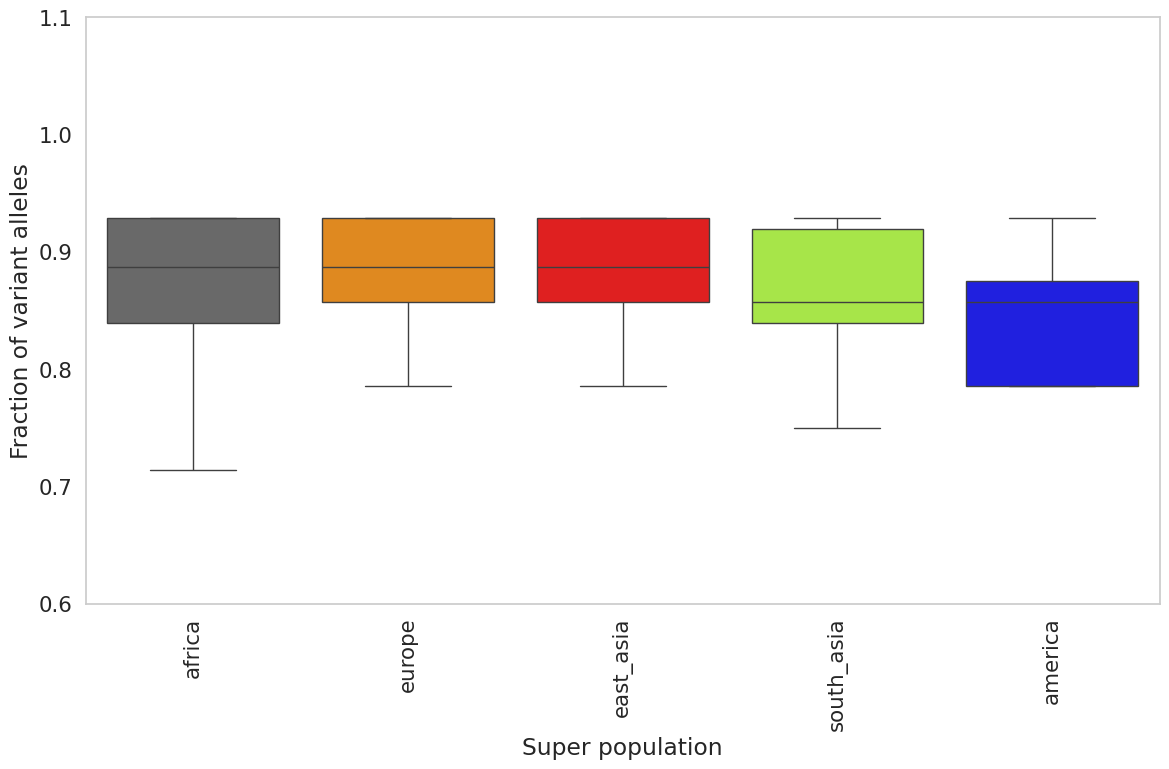

In [23]:
colors = ["dimgrey", "darkorange", "red", "greenyellow", "blue", "purple"]

color_dict = dict(zip(super_populations, colors))
sns.set(rc={'figure.figsize':(12,8)},font_scale = 1.4)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(data=df, palette=color_dict)
ax.set(xlabel='Super population', ylabel='Fraction of variant alleles')
ax.set_ylim(0.6,1.1)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("downstream/fraction_of_variant-alleles.pdf", dpi=1200)

### Population-specific allele distributions

In the next code cells, we investigate the distribution of TR lengths of variant alleles for all super populations

In [2]:
%%bash 

# get genotype statistics using statSTR

populations=("africa" "europe" "east_asia" "south_asia" "america")

for population in "${populations[@]}"; do

    statSTR \
        --vcf output/ensembletr_output/ensembletr.vcf.gz \
        --vcftype hipstr \
        --thresh --afreq --use-length \
        --out downstream/"${population}"_stats \
        --samples str_resources/"${population}"_sample_ids.txt

done

# Get list of STR, period, diff, AF
# python get_diff_af.py output/ensembletr_output/ensembletr.vcf.gz > downstream/diff_afreqs.tab


# For each sample, count how many alleles match ref, ref+1, ref-1, etc.
# Do separately for homopolymers and non-homopolymers
python summarize_allele_sizes.py output/ensembletr_output/ensembletr.vcf.gz > downstream/asize_summary.tab


Done

Done

Done

Done

Done


/home/ibra/protocol/genotyping_repeats_tutorial/summarize_allele_sizes.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["Superpopulation"] = samples["Superpopulation"].apply(GetPopOrder)
Reading records
HG02105
HG02330
HG03885
HG01097
NA19746
HG01054
HG03385
NA19734
HG01628
HG02181
HG01365
HG00457
HG01841
HG03733
HG02006
NA19670
NA21093
HG03848
HG04003
HG01063
HG00437
NA18559
NA20802
HG03060
HG01976
HG01383
HG03830
HG01468
NA11830
HG01807
HG02804
NA19064
NA19700
HG00342
HG03024
NA18974
NA18510
HG02139
NA19079
NA20278
NA20542
HG01685
HG02061
HG00343
NA19107
HG00188
HG02465
HG03595
NA18639
NA19024
HG00231
HG00613
HG02861
HG03458
HG02649
HG01673
HG03054
HG03868
HG00671
HG00242
HG01679
HG03472
NA19066
HG00185
NA19752
NA18909
HG01863
HG012

In [3]:
####### Set up #########
def GetSuperpopColors(spop):
    if "Europe" in spop: return "blue"
    if "Africa" in spop: return "gold"
    if "America" in spop: return "red"
    if "East Asia" in spop: return "green"
    if "South Asia" in spop: return "purple"


/tmp/ipykernel_18185/2616374391.py:11: FutureWarning: The provided callable <function sum at 0x7fdd306d8cc0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby(["spop","type"], as_index=False).agg(aggdict)
/tmp/ipykernel_18185/2616374391.py:11: FutureWarning: The provided callable <function sum at 0x7fdd306d8cc0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby(["spop","type"], as_index=False).agg(aggdict)


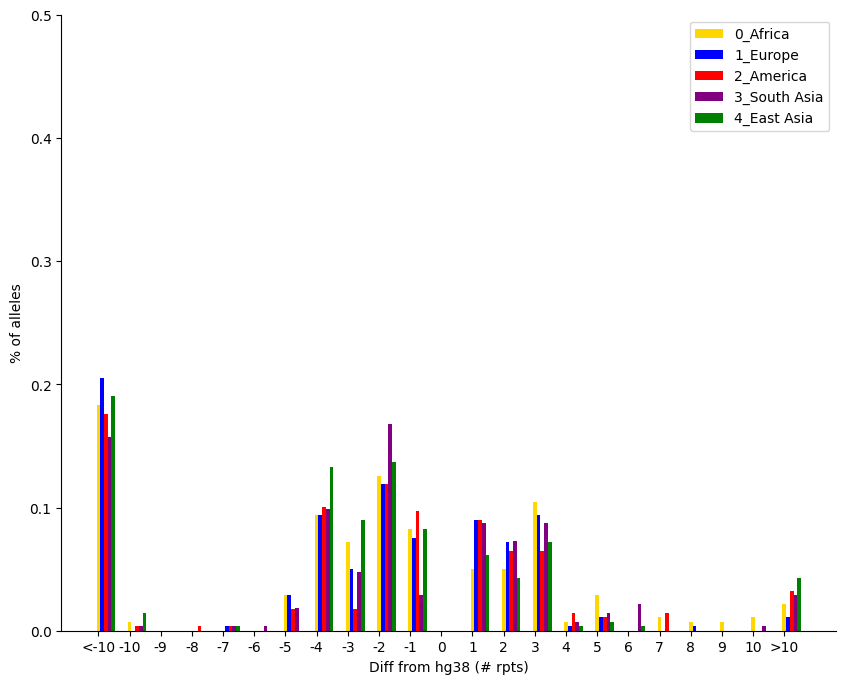

In [9]:
# Load data, sum across all chromosomes
# data gives counts of allele sizes in each sample,
# separately for homopolymers/non-homopolymers

sizecols = list(range(-11, 12))
data = pd.read_csv("downstream/asize_summary.tab", sep="\t", names=["sample","spop","pop","type"] + sizecols)

# Aggregate by summarizing across samples/chromosomes
aggdict = {}
for i in sizecols: aggdict[i] = np.sum
data = data.groupby(["spop","type"], as_index=False).agg(aggdict)

w = 0.12
vtype = "other"

byspop = data[data["type"]==vtype].copy()
byspop.index = byspop["spop"]
byspop = byspop.drop(columns = ["spop","type"])
byspop = byspop.div(byspop.sum(axis=1), axis=0)
byspop[0] = np.nan

fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111)
i = 0
for spop in sorted(list(byspop.index)):
    vals = byspop.loc[spop]
    color = GetSuperpopColors(spop)
    ax.bar([item+w*i for item in sizecols], vals, color=color, label=spop, width=w)
    i += 1
ax.legend(loc="upper right")
ax.set_xticks(sizecols)
ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
ax.set_xlabel("Diff from hg38 (# rpts)")
ax.set_ylabel("% of alleles")
ax.set_ylim(bottom=0, top=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

figname = "DiffFromRef-Nonhomopolymer.pdf"
fig.savefig(os.path.join("downstream", figname))

Now, we zoom into some loci to investigate population-specific allele distributions. The x-axis denotes the allele length (number of repeats relative to hg38) and the y-axis denotes the frequency of each allele under investigation.

In [ ]:
%%bash
# CHROM="1"
# START=77887913

# CHROM="4"
# START=3074877

# CHROM="11"
# START=57528484

# CHROM="14"
# START=64253561

# CHROM="17"
# START=51831668

CHROM="21"
START=43776443

statSTR \
    --vcf output/ensembletr_output/ensembletr.vcf.gz \
    --vcftype hipstr \
    --afreq --use-length \
    --region chr${CHROM}:${START}-${START} \
    --out downstream/chr${CHROM}.${START}_stats \
    --samples str_resources/africa_sample_ids.txt,str_resources/america_sample_ids.txt,str_resources/europe_sample_ids.txt,str_resources/east_asia_sample_ids.txt,str_resources/south_asia_sample_ids.txt \
    --sample-prefixes africa,america,europe,east_asia,south_asia


In [15]:
def GetRowColors(spop):
    if "europe" in spop: return "blue"
    if "africa" in spop: return "gold"
    if "america" in spop: return "red"
    if "east_asia" in spop: return "green"
    if "south_asia" in spop: return "purple"

def plot_locus_allele_distribution(filepath = str):

    data = pd.read_csv(filepath_or_buffer = filepath, sep="\t")

    if data.shape[0] != 1:
        assert("Need to find exactly one locus!")

    fig = plt.figure()
    fig.set_size_inches((8, 8))
    popnum = 0
    w = 0.15

    for pop in ["africa", "europe", "east_asia", "south_asia", "america"]:

        ax = fig.add_subplot(6, 1, popnum+1)
        vals = data["afreq-%s"%pop].values[0]
        xvals = []
        yvals = []
        for ainfo in vals.split(","):
            allele, freq = ainfo.split(":")
            allele = int(float(allele))
            freq = float(freq)
            xvals.append(allele)
            yvals.append(freq)
        ax.bar(xvals, yvals, color=GetRowColors(pop), edgecolor="black", label=pop, width=1)
        ax.legend(loc="upper right")
        popnum += 1
        ax.set_xlim(left=0, right=80)
        
    ax.legend(loc="upper right");
    ax.set_xlabel("Allele length")
    ax.set_ylabel("Frequency");


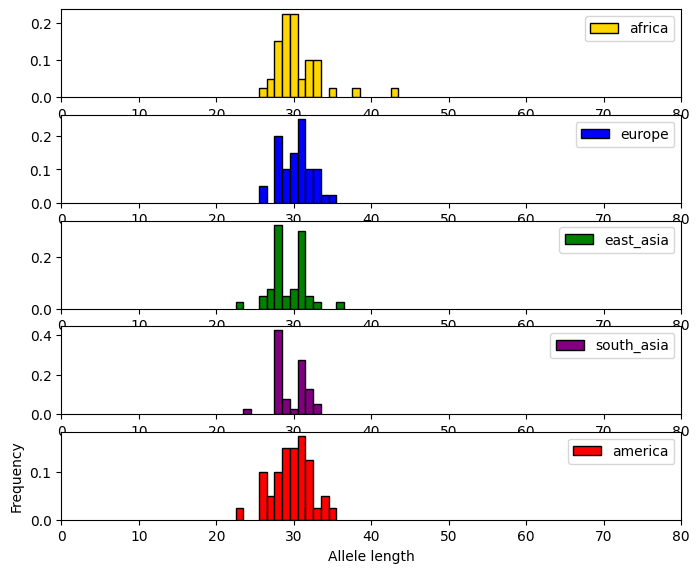

In [18]:
plot_locus_allele_distribution("downstream/chr4.3074877_stats.tab")

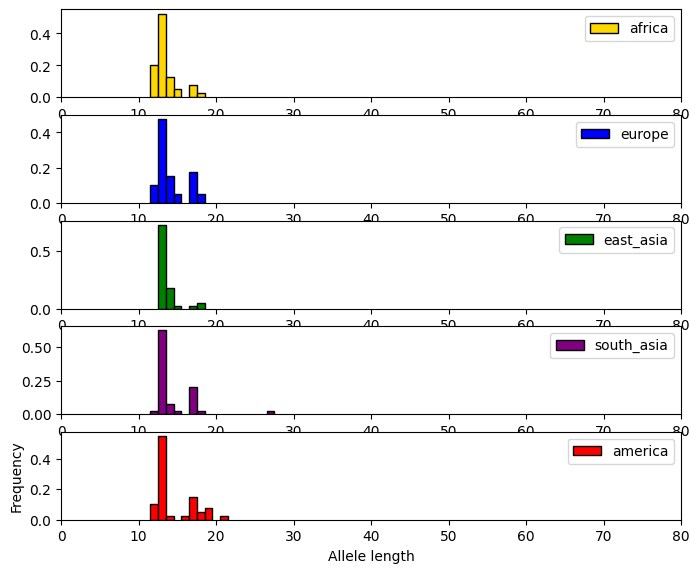

In [19]:
plot_locus_allele_distribution("downstream/chr11.57528484_stats.tab")

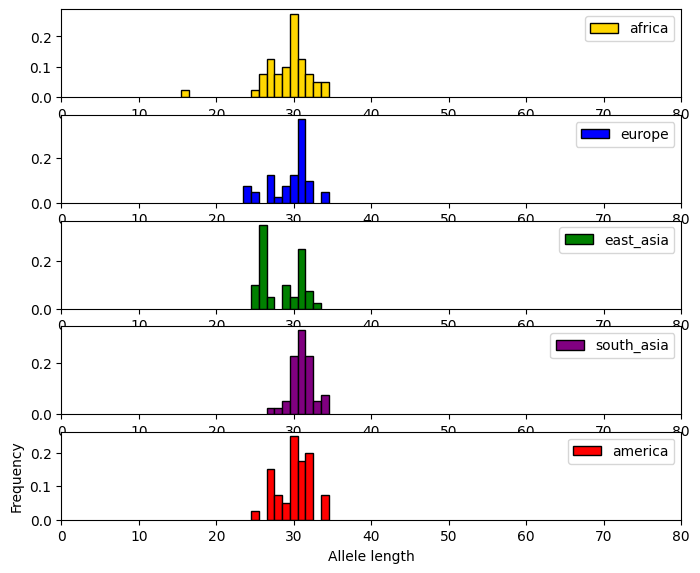

In [21]:
plot_locus_allele_distribution("downstream/chr14.64253561_stats.tab")

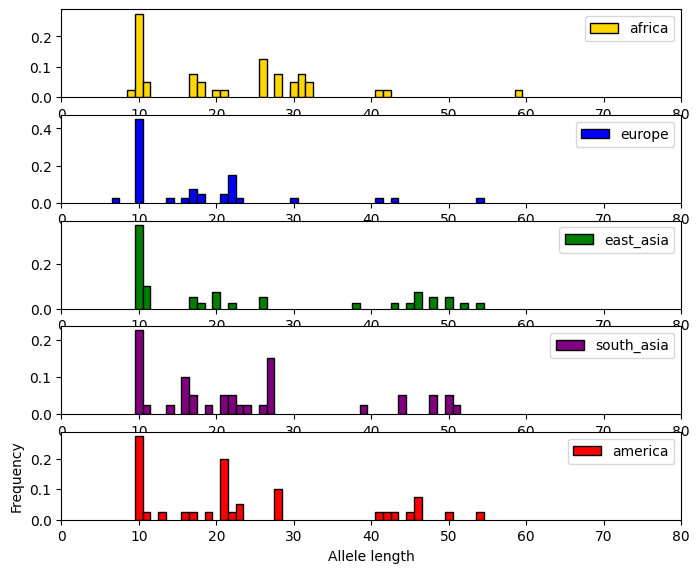

In [22]:
plot_locus_allele_distribution("downstream/chr17.51831668_stats.tab")

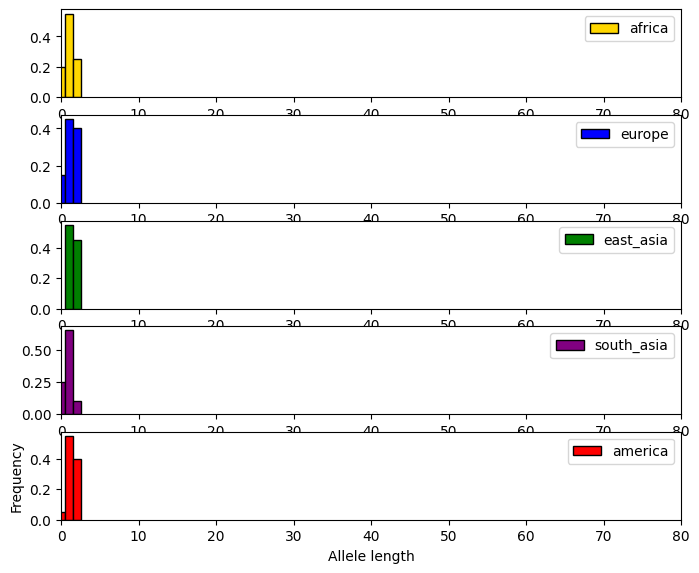

In [23]:
plot_locus_allele_distribution("downstream/chr21.43776443_stats.tab")

# Identifying associations between STRs and comples traits with associaTR

In this example, we use the example dataset in TRTools to demostrate how to performs association analysis between STRs and a trait under investigation

In [28]:
!associaTR --help

usage: associaTR [-h] [--vcftype {eh,hipstr,gangstr,popstr,advntr}]
                 [--same-samples] [--sample-list SAMPLE_LIST]
                 [--region REGION] [--non-major-cutoff NON_MAJOR_CUTOFF]
                 [--beagle-dosages] [--version]
                 outfile tr_vcf phenotype_name traits [traits ...]

positional arguments:
  outfile
  tr_vcf
  phenotype_name        name of the phenotype being regressed against
  traits                At least one (possibly more) .npy 2d float array
                        files, containing trait values for samples. The first
                        trait from the first file is the phenotype to be
                        regressed against, all other traits from that file are
                        used as covariates. Additional files can be listed to
                        add additional covariates. If --same-samples is not
                        specified, the first column of each file must be the
                        numeric samp

In [ ]:
associaTR 